## PFSS modeling with pfsspy

Sam Badman - 11/4/22

This notebook goes through running a potential field source surface (PFSS, [1](https://ui.adsabs.harvard.edu/abs/1969SoPh....9..131A/abstract),[2](https://ui.adsabs.harvard.edu/abs/1969SoPh....6..442S/abstract)) model of the solar coronal magnetic field using [`pfsspy`](https://pfsspy.readthedocs.io/en/stable/) and accessing its components including tracing fieldlines, creating a map of coronal holes and flying a model spacecraft through it and tracing field line connections

#### The Potential Field Source Surface (PFSS) Model

The PFSS model is the simplest physical model of the solar coronal magnetic field that gives non-trivial/useful structure. It assumes a current free corona ($\nabla \times \boldsymbol{B} = 0$) and combined with the no-monopole Maxwell equation, results in the ability to express the magnetic field as a scalar __potential__ ($\boldsymbol{B} = -\nabla \phi_B$) which obeys Laplace's equation:

$$
\nabla^2 \phi_B = 0
$$

which can be solved once appropriate boundary conditions are defined. For the PFSS model, we define one boundary of a sphere at $R=1R_\odot$ (effectively the solar photosphere), and another sphere with a larger radius ($R_{SS}$), called the source surface. On the inner boundary, we specify the magnetic field as a radial vector as determined by magnetograph measurements (more on that below). 

On the outer boundary, a clever innovation is made: the boundary is specified to be an equipotential, or equivalently, that the field is perpendicular to the boundary everywhere (i.e. radial). This is how the model produces magnetic topology which approximates the outflowing soalr wind: It enforces the existence of magnetically open field lines at the outer boundary of the model, simulating how the outflowing solar wind plasma drags field lines with it, despite not having any intrinsic plasma physics in the governing equations.   

#### `pfsspy`

This notebook (and my [PhD thesis](https://escholarship.org/uc/item/53b3m528) to a large extent!) are built on an implementation of the PFSS model in python called `pfsspy`, written by David Stansby (Stansby+[2020](https://joss.theoj.org/papers/10.21105/joss.02732)) using a PFSS numerical solver first implemented in python by Anthony Yeates (Yeates [2018](https://ui.adsabs.harvard.edu/abs/2018zndo...1472183Y/abstract)) based on a finite-difference solver by van Ballegooijen+[2000](https://iopscience.iop.org/article/10.1086/309265)).

Read more about `pfsspy` here : https://pfsspy.readthedocs.io/en/stable/ and view the source code here : https://github.com/dstansby/pfsspy/tree/0c5b78a2901c5dd55ddc286ba25a91717e85a40c

In [2]:
# Check modules and versions
import pfsspy, sunpy, astropy, matplotlib, numpy, astrospice
for module in [pfsspy,sunpy,astropy,matplotlib,numpy, astrospice] :
    print(module.__name__, module.__version__)

pfsspy 1.1.2
sunpy 4.0.5
astropy 5.1
matplotlib 3.5.2
numpy 1.21.5
astrospice 0.2.0


In [3]:
# Modules used in this notebook

# Built-in
import urllib.request
import os, datetime

# Standard scientific
import matplotlib.pyplot as plt
import numpy as np

# Astro/solar/helio-specific
import pfsspy
import sunpy.map
import astropy.coordinates
import astropy.units as u
import astrospice


### 1) Downloading a magnetogram

The basic ingredient we need for a PFSS model is a boundary condition of the solar magnetic field at the photosphere. To work, these should be FITS files which are binned in longitude vs latitude over 360 degrees and -90 - +90 degrees respectively. There are many possible options (GONG,WSO,ADAPT,...). Here we show how to download an ADAPT-GONG magnetogram. 

ADAPT reference : (Arge et al. [2010](https://ui.adsabs.harvard.edu/abs/2010AIPC.1216..343A/abstract))

ADAPT-GONG maps for a given year are located in the directory tree (here shown for 2021) : 

`https://gong.nso.edu//adapt/maps/gong/2021/`  

and there are compressed FITS files every 2 hours with file names like :

`adapt40311_03k012_202103300800_i00005700n1.fts.gz`

where the main thing we are interested in changing is the date and time. For this example, the map is for 2021/3/30 at 0800UT. Files exist for each day for hours `0000,0200,0400... 2200` 

You could just go to the url above and double click the file to download the one you want. We can do it from python with the urllib.request module:

In [4]:
# Note this has been tested in a Linux environment, I'm
# not 100% if this will work in Windows. Worst case, go to the URL above
# and download manually to the same folder as this notebook
filename = "adapt40311_03k012_202103300800_i00005700n1.fts.gz"
remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2021"
local_path = "."
if not os.path.exists(f"./{filename}") :
    urllib.request.urlretrieve(f"{remote_path}/{filename}", 
                               f"{local_path}/{filename}"
                              )

which grabs the March 30 2021, 8am ADAPT map and saves it to the current working directory (i.e. where you are running this notebook from). 

### 2) Loading and plotting the magnetogram

In this next step, we are going to do a lot in one go. We will:
* Load in the ADAPT map we just downloaded
* Extract a single magnetogram from the file and cast it into a format ready for input into pfsspy
* Run a PFSS coronal model from this input using `pfsspy`

Here is a function that reads in ADAPT maps and loads them into a PFSS model. We also have an option to return just the input magnetogram as a `sunpy.map` so we can see what it looks lie.

In [86]:
def adapt2pfsspy(filepath, #must already exist on your computer
                 rss=2.5, # Source surface height
                 nr=60, # number of radial gridpoiints for model
                 realization="mean", #which slice of the adapt ensemble to choose
                 return_magnetogram = False # switch to true for function to return the input magnetogram
                ):

    # Load the FITS file into memory
    # ADAPT includes 12 "realizations" - model ensembles
    # pfsspy.utils.load_adapt is a specific function that knows
    # how to handle adapt maps
    adaptMapSequence = pfsspy.utils.load_adapt(filepath)
    # If realization = mean, just average them all together
    if realization == "mean" : 
        br_adapt_ = np.mean([m.data for m in adaptMapSequence],axis=0)
        adapt_map = sunpy.map.Map(br_adapt_,adaptMapSequence[0].meta)
    # If you enter an integer between 0 and 11, the corresponding
    # realization is selected
    elif isinstance(realization,int) : adapt_map = adaptMapSequence[realization]
    else : raise ValueError("realization should either be 'mean' or type int ") 
    
    # pfsspy requires that the y-axis be in sin(degrees) not degrees
    # pfsspy.utils.car_to_cea does this conversion
    adapt_map_strumfric = pfsspy.utils.car_to_cea(adapt_map)

    # Option to return the magnetogram
    if return_magnetogram : 
        return adapt_map_strumfric
    # Otherwise run the PFSS Model and return
    else :
        # ADAPT maps input are in Gauss, multiply by 1e5 to units of nT
        adapt_map_input = sunpy.map.Map(adapt_map_strumfric.data*1e5,
                                        adapt_map_strumfric.meta)
        peri_input = pfsspy.Input(adapt_map_input, nr, rss)
        peri_output = pfsspy.pfss(peri_input)
        return peri_output


First, run with the option to return the magnetogram to see what the input is

In [87]:
filepath = f"{local_path}/{filename}"
adapt_magnetogram = adapt2pfsspy(filepath,return_magnetogram=True)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


What we receive here is a `sunpy.map.Map` object, which has it's own plot method defined:

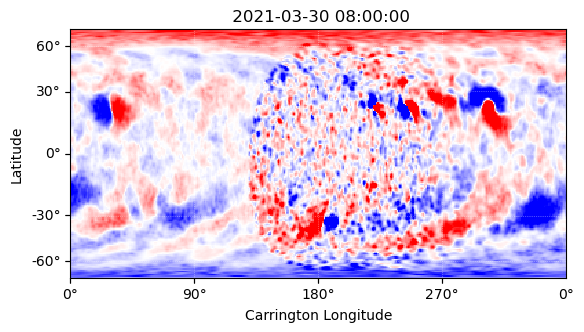

In [88]:
adapt_magnetogram.plot(cmap="bwr",vmin=-10, vmax=10)

What we have here is a map of the radial component of the Sun's magnetic field at the photosphere as a function of longitude and latitude (i.e. covering the whole Sun). 

The blue colors are negative polarity where the field lines point into the sun, and the red where they point outwards. You'll notice strong field in the North and South poles, which is a distinct feature of solar minimum. You'll also notice a boundary surrounding sharper looking data inside and smoother data outside. This is a property of ADAPT whic assimilates recent "measured" data (the sharp resolution region) from the Earth facing part of the disk, and models the rest of the sun with what's called a surface flux transport model. That model applied to the data smooths out the structures.

### 3) Running the PFSS Model

This magnetogram above is what drives a PFSS model, as a boundary condition at the inner boundary. At the outer boundary, the model states that the magnetic field should be radially oriented at a spherical boundary called the "source surface". All that is needed to specify this is the radius of this surface, called the source surface height, or $R_{SS}$. The canonical value ([Hoeksema 1984](https://ui.adsabs.harvard.edu/abs/1984PhDT.........5H/abstract)) is 2.5$R_\odot$. 

Let's run the PFSS model for our downloaded map and this canonical value

In [89]:
pfss_model = adapt2pfsspy(filepath,rss=2.5)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]


This has produced a `pfsspy.Output` object (see https://pfsspy.readthedocs.io/en/stable/api/pfsspy.Output.html ). This is essentially, the coronal magnetic field vector on a 3D grid between $1R_\odot$ and $R_{SS}$ with some methods built on top of it. 

First, let's just look at how the data is recorded inside the model. The magnetic field vector is evaluated on a grid which we can access with its [`pfsspy.Output.grid`](https://pfsspy.readthedocs.io/en/stable/api/pfsspy.grid.Grid.html) class. The class contains properties `rg`, `sg` and `pg` which are the grid _vertices_ for log(radius), _sine_ latitude and longitude (p for $\phi$). Equivalent `rc`,`sc` and `pg` properties are the _cell centers_. Note the _log_ radius and _sine_ latitude define the Strumfric grid, which is the way space is binned in 3D in `pfsspy`. To get things in standard heliographic coordinates :

In [81]:
radii = np.exp(pfss_model.grid.rg)
latitudes = np.degrees(np.arcsin(pfss_model.grid.sg)) 
longitudes = np.degrees(pfss_model.grid.pg)

And let's plot plot a longitudinal slice of the grid to see the slightly non-standard grid spacing

(0.0, 2.5)

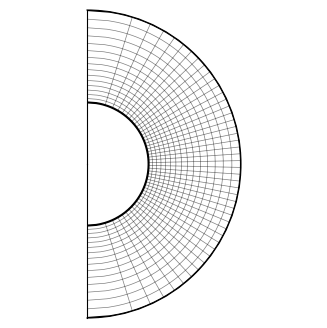

In [82]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(projection="polar")
ax.set_rlim(1,2.5)
ax.set_xticks([]);ax.set_yticks([])

ax.plot(np.radians(latitudes),[1]*len(latitudes),color="black")
for r in radii[::4] : ax.plot(np.radians(latitudes),[r]*len(latitudes),color="black",alpha=0.5,linewidth=0.5)
ax.plot(np.radians(latitudes),[2.5]*len(latitudes),color="black")
for lat in np.radians(latitudes[::4]) : ax.plot([lat,lat],[radii[0],radii[-1]],color="black",alpha=0.5,linewidth=0.5)

ax.set_aspect(1); ax.set_thetalim(-np.pi/2,np.pi/2)
ax.set_rlim(0,2.5)

The magnetic field vector can be accessed at each grid vertex with the `pfsspy.Output.bg` and equivalently at each grid cell center with `pfsspy.Output.bc`. The former is a 4D `numpy.array` whose last index (dimension = 3) is the field component in the azimuthal, latitudinal and radial directions, respectively. The latter is a 3 element tuple containing field vector components in the radial, latitudinal and azimuthal components.

This is really what a PFSS model actually _does_ -> takes an input magnetogram and source surface height, and spits out the 3D magnetic field vector in the 3D region defined above. Everything else we'll do here is just deriving properties from this 3D solution.

A very easy first thing to do is to take a look at radial field at the source surface, which `pfsspy` exposes as a `sunpy.map.Map`, and `sunpy.map.Map` have their own plotting method built in.

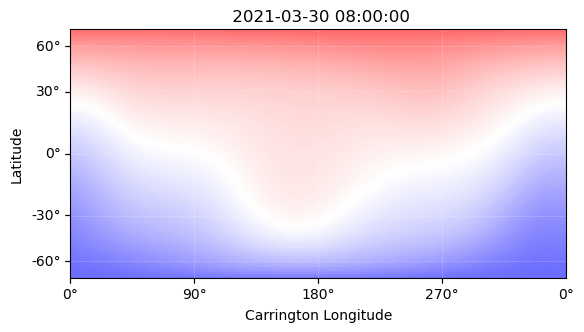

In [92]:
pfss_model.source_surface_br.plot(cmap="bwr",vmin=-5e4,vmax=5e4)

We can immediately see some large scale structure of the solar corona: There is a dipole-dominated structure with strong positive field in the northern hemisphere, and negative field in the south. A neutral line (white) in the above plot advects out to becomes the heliospheric current sheet in interplanetary space and is a good predictor of where and when interplanetary spacecraft will change the predominant magnetic polarity they are measuring (allowing for the Parker spiral). `pfsspy` actually also exposes the contour of this neutral line which you can access via `pfsspy.Output.source_surface_pils` where "pil" stands for "polarity inversion line".

Additionally, we can compare this plot to the magnetogram we plotted above, and immediately see a key intuition about the coronal field, which is that the higher order, smaler scale structure tends to decay away with height from the Solar surface, while the largest scale structure survives for longer.

### 4) Magnetic Field Line Tracing

One `pfsspy.Output` method which is extremely useful is a field line tracing method. We can use this to trace field lines all over the Sun as follows.

In [8]:
# Define function which does the field line tracing
def pfss2flines(pfsspy_output, # pfsspy output object
                nth=18,nph=36, # number of tracing grid points
                rect=[-90,90,0,360], #sub-region of sun to trace (default is whole sun)
                trace_from_SS=False, # if False : start trace from photosphere, 
                                     #if True, start tracing from source surface
                skycoord_in=None, # Use custom set of starting grid poitns
                max_steps = 1000 # max steps tracer should take before giving up
                ) :
    
    # Tracing if grid
    if skycoord_in is None  :
        [latmin,latmax,lonmin,lonmax]=rect
        lons,lats = np.meshgrid(np.linspace(lonmin,lonmax,nph),
                                np.linspace(latmin,latmax,nth)
                                )
        if not trace_from_SS : alt = 1.0*u.R_sun # Trace up from photosphere
        else : alt = po.grid.rss*u.R_sun  # Trace down from ss
        alt = [alt]*len(lons.ravel())
        seeds = astropy.coordinates.SkyCoord(lons.ravel()*u.deg,
                               lats.ravel()*u.deg,
                               alt,
                               frame = pfsspy_output.coordinate_frame)
        
    # Tracing if custom set of points
    else : 
        skycoord_in.representation_type = "spherical"
        seeds = astropy.coordinates.SkyCoord(skycoord_in.lon,
                               skycoord_in.lat,
                               skycoord_in.radius,
                               frame = pfsspy_output.coordinate_frame)
        
    return pfsspy_output.trace(pfsspy.tracing.FortranTracer(max_steps=max_steps),seeds)

In [9]:
# Run it on the default grid, starting from the photosphere
flines = pfss2flines(pfss_model)

/home/sbadman/anaconda3/lib/python3.9/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


### 5) Visualizing the Output

Now we can make our first plot of the Sun's magnetic field!

Text(0.5, 0.92, 'PFSS - file=adapt40311_03k012_202103300800_i00005700n1.fts.gz - rss=2.5Rs')

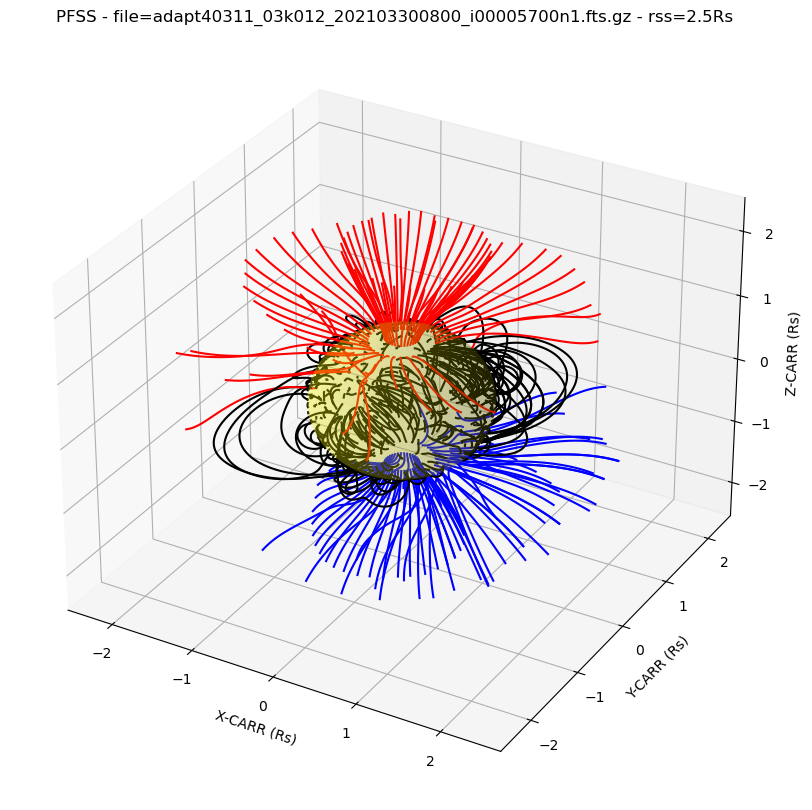

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# Make a fake sphere to represent the Sun
lonm,latm = np.meshgrid(np.linspace(0,360,180)*u.deg,
                        np.linspace(-90,90,90)*u.deg)
xm,ym,zm = np.cos(latm)*np.cos(lonm),np.cos(latm)*np.sin(lonm),np.sin(latm)
ax.plot_surface(xm,ym,zm,alpha=0.2,color="yellow")

color_dict = {-1:"blue",0:"black",1:"red"}
for f in flines :
    fcoords = f.coords
    fcoords.representation_type="cartesian"
    ax.plot(fcoords.x.to("R_sun"),
            fcoords.y.to("R_sun"),
            fcoords.z.to("R_sun"),
            color = color_dict.get(f.polarity)
           )
ax.set_xlabel("X-CARR (Rs)")
ax.set_ylabel("Y-CARR (Rs)")
ax.set_zlabel("Z-CARR (Rs)")

ax.set_title(f"PFSS - file={os.path.basename(filename)} - rss=2.5Rs")

We have 3 types of field lines identified here. Red and blue are "open" meaning one end touches the photosphere and the other the source surface, and refer to positive and negative polarity respectively (vector away from or towards the Sun). Both allow solar plasma to freely travel outwards to contribute to the solar wind.

Black field lines are "closed" meaning both ends of the field line touch the photosphere and trap plasma.

Note that here the closed field lines are concentrated around the equator, while the open field lines come from the north and south poles - this is the standard picture around solar minimum.

### 6) Coronal Hole Mapping

Now that we know how to trace field lines through the model, we can ask the question: "Where on the Sun are the open field lines coming from?" The answer is from "coronal holes", which are regions of the Sun's surface which appear dark in EUV. See for example https://stereo-ssc.nascom.nasa.gov/browse/2021/03/30/ 

To do this, we repeat the tracing but at a much higher resolution, and record which field lines are open and which are closed.

In [11]:
flines_highres = pfss2flines(pfss_model,nth=181,nph=361)

The field line topology is defined by the "polarity" attribute of each field line.

In [12]:
topologies = flines_highres.polarities.reshape([181,361])

We can now plot the open/closed contours as a colormap

Text(0.5, 1.0, 'Coronal Hole Map - file=adapt40311_03k012_202103300800_i00005700n1.fts.gz - Rss=2.5Rs')

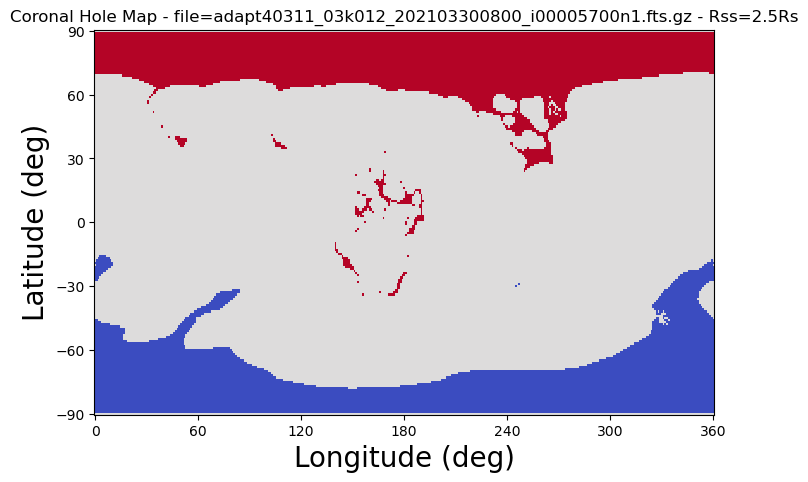

In [13]:
lons = np.linspace(0,360,361)
lats = np.linspace(-90,90,181)
fig,ax = plt.subplots(figsize=(8,5))
ax.pcolormesh(lons,lats,topologies,cmap="coolwarm")
ax.set_xlabel("Longitude (deg)",fontsize=20)
ax.set_ylabel("Latitude (deg)",fontsize=20)
ax.set_xticks(np.linspace(0,360,7))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_title(f"Coronal Hole Map - file={filename} - Rss=2.5Rs")

As expected, the positive open field lines (red) come from the norther latitudes, and the negative open field lines (blue), come from the southern latitudes

### 7) Flying PSP through the model

Lastly, let's look at an example of drawing connections between points on the Sun with a heliospheric spacecraft.

This requires 3 steps :

1) Produce the spacecraft trajectory in a frame that moves with the Sun

2) Project the trajectory down to 2.5Rs using the Parker Spiral

3) Draw field lines through the PFSS model from this projected trajectory. 

For step 1 we will use [astrospice](https://github.com/astrospice/astrospice). You can see a more complete explanation of what we're doing here in this notebook : https://github.com/STBadman/PublicProjects/blob/master/Visualizations/PlottingSpacecraftTrajectoriesAstrospice.ipynb 

We will use the final cell in that notebook, which produces an `astropy.coordinates.SkyCoord` object containing the PSP trajectory at specified timestamps.

We need the astrospice library 

`!pip install astrospice`

and the built in `datetime` library.

and the `sunpy.coordinates` library

In [14]:
# Load in PSP Spice Kernels (download happens automatically)
kernels = astrospice.registry.get_kernels('psp','recon') 

# Generate a list of timestamps to generate the spacecraft positions at
timestamps = [datetime.datetime(2021,3,1)+datetime.timedelta(hours=d) 
              for d in range(60*24)
             ] 

# Create the coordinates. We need the spice string "SOLAR PROBE PLUS"
# This produces 
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS',timestamps)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

Files Downloaded:   0%|          | 0/22 [00:00<?, ?file/s]

Next, visualize the trajectory

Text(0, 0.5, 'Y-CARR (R_sun)')

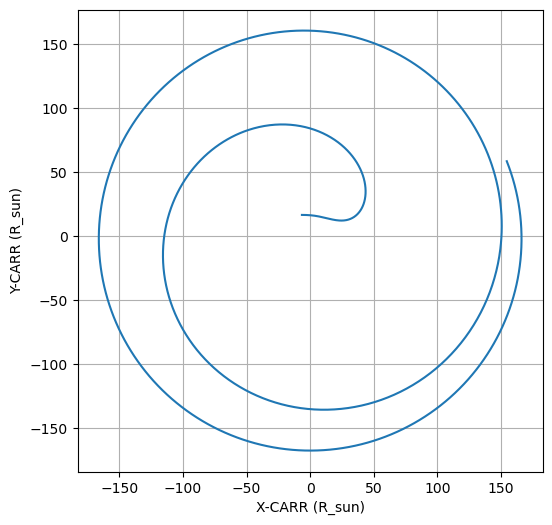

In [15]:
fig,ax=plt.subplots(figsize=(6,6))
unit = "R_sun"

psp_coords_carr.representation_type="cartesian" # set to spherical to access radius, lat and lon

ax.plot(psp_coords_carr.x.to(unit),psp_coords_carr.y.to(unit))
ax.grid()

ax.set_xlabel(f"X-CARR ({unit})")
ax.set_ylabel(f"Y-CARR ({unit})")

Now onto step 2, Parker spiral projection. 

We want to go from PSP's location out in the heliosphere down close to the Sun so that we can trace the field lines through the PFSS model. To do this we assume the connection is a Parker spiral, and what that means in practice is that we only correct longitude and radius, the latitude remains fixed. See figures in [Badman+2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..246...23B/abstract) for some images of what this looks like for PSP's trajectory 

The functional form of the Parker spiral is quite simple :

$$
\begin{align} 
    B_R(R,\theta,\phi) &= B(R_0,\theta,\phi_0) \bigg(\frac{R_0}{R}\bigg)^2 \label{intro:eqn:parkerfield1} \\
    B_\theta(R,\theta,\phi) &= 0 \label{intro:eqn:parkerfield2} \\
    B_\phi(R,\theta,\phi) &= -B(R_0,\theta,\phi_0) \frac{\Omega_{\odot} R_0}{V_{SW}}\frac{R_0}{R}\sin\theta \label{intro:eqn:parkerfield3}
\end{align}
$$

with $\Omega_\odot$ representing the solar rotation rate with respect to the stars, and $V_{SW}$ representing the solar wind velocity. 

For a fixed solar wind speed the longitudinal offset for the spiral connecting points at radii $r_0$ and $r_1$ is also easy to write down as :

$$
\Delta \phi = \Omega_\odot (r_1 - r_0)/V_{SW}
$$

so in python, making the projection is quite easy:

In [16]:
# Define function to do the longitudinal correction
def delta_long(r,vsw=360.*u.km/u.s,omega_sun=14.713*u.deg/u.d,rss=2.5):
    return omega_sun * (r - rss * u.R_sun) / vsw

rss = 2.5*u.R_sun
psp_coords_carr.representation_type = "spherical"
psp_at_source_surface = astropy.coordinates.SkyCoord(
    radius = rss * np.ones(len(psp_coords_carr)),
    ## The projection can also take a varying solar wind speed as an input
    lon = psp_coords_carr.lon + delta_long(psp_coords_carr.radius,rss=rss.value),
    lat = psp_coords_carr.lat,
    frame = sunpy.coordinates.HeliographicCarrington(observer="self")
)

To compare, we can plot the trajectory latitude and longitude for both the original spacecraft coordinates, and the projected version.

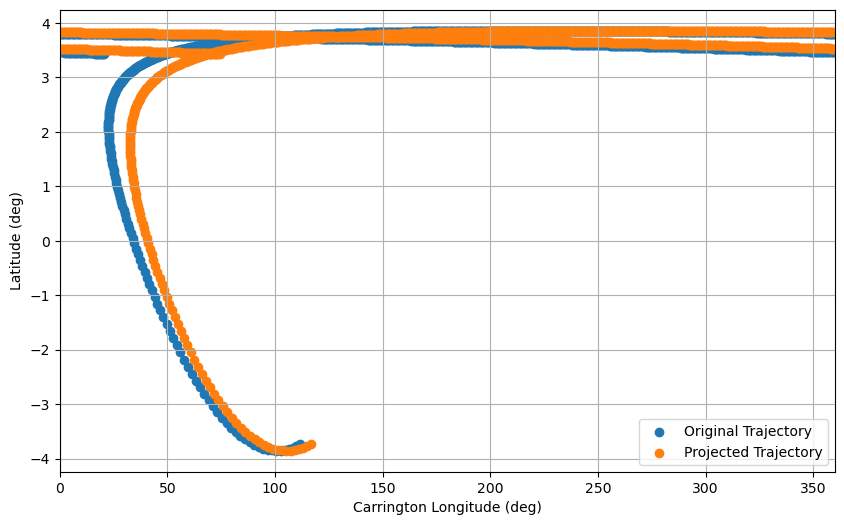

In [17]:
fig,ax = plt.subplots(figsize=(10,6))

psp_coords_carr.representation_type="spherical"
ax.scatter(psp_coords_carr.lon,psp_coords_carr.lat,label="Original Trajectory")
ax.scatter(psp_at_source_surface.lon,psp_at_source_surface.lat,label="Projected Trajectory")

ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Latitude (deg)")

ax.set_xlim(0,360)

ax.grid()

ax.legend()

You'll notice a small offset between the blue and orange traces, and at the bottom of the plot the offset decreases as PSP gets closer to the Sun.

We can also visualize the spiral field lines in the equatorial plane:

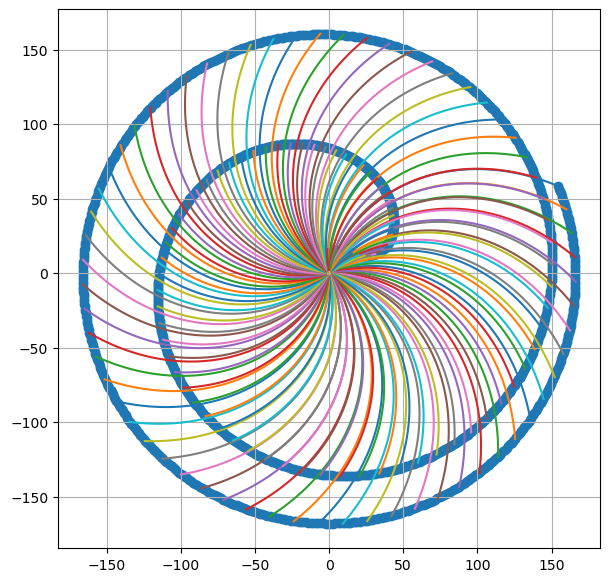

In [18]:
def parker_streamline(phi_0=0.0,r0=1.0,sampling=100,
                      w_s=(2.*np.pi)/(24.47*(24*3600)),
                      v_sw=360e3,rmax=215) :
    # Output r :: Rs, phi :: deg
    r = np.linspace(r0,rmax,sampling)*u.R_sun
    r0 = r0*u.R_sun
    phi = np.degrees(-w_s/v_sw*(r.to("m").value-r0.to("m").value)) + phi_0
    return r.value,phi


psp_at_source_surface.representation_type="spherical"
psp_coords_carr.representation_type="spherical"
spirals = [parker_streamline(phi_0=coord.lon.value,
                             r0=coord.radius.to("R_sun").value,
                             rmax=r_outer.to("R_sun").value
                            ) 
           for coord,r_outer in zip(psp_at_source_surface,psp_coords_carr.radius)
          ]

fig,ax = plt.subplots(figsize=(7,7))

psp_coords_carr.representation_type="cartesian"
ax.scatter(psp_coords_carr.x.to("R_sun"),psp_coords_carr.y.to("R_sun"))

psp_at_source_surface.representation_type="cartesian"
ax.scatter(psp_at_source_surface.x.to("R_sun"),psp_at_source_surface.y.to("R_sun"))

for spiral in spirals[::10] :
    ax.plot(spiral[0]*u.R_sun*np.cos(spiral[1]*u.deg),
            spiral[0]*u.R_sun*np.sin(spiral[1]*u.deg)
           )

ax.grid()



Finally we can do step 3 to trace the field lines from PSP's projected position. This is straightforward to do with the custom coordinates input defined in the field line tracing function above.

In [19]:
flines_psp = pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)

Finally, let's make our visualization of the Sun again but only show the field lines sampled by PSP

Text(0.5, 0.92, 'PFSS - file=adapt40311_03k012_202103300800_i00005700n1.fts.gz - rss=2.5Rs')

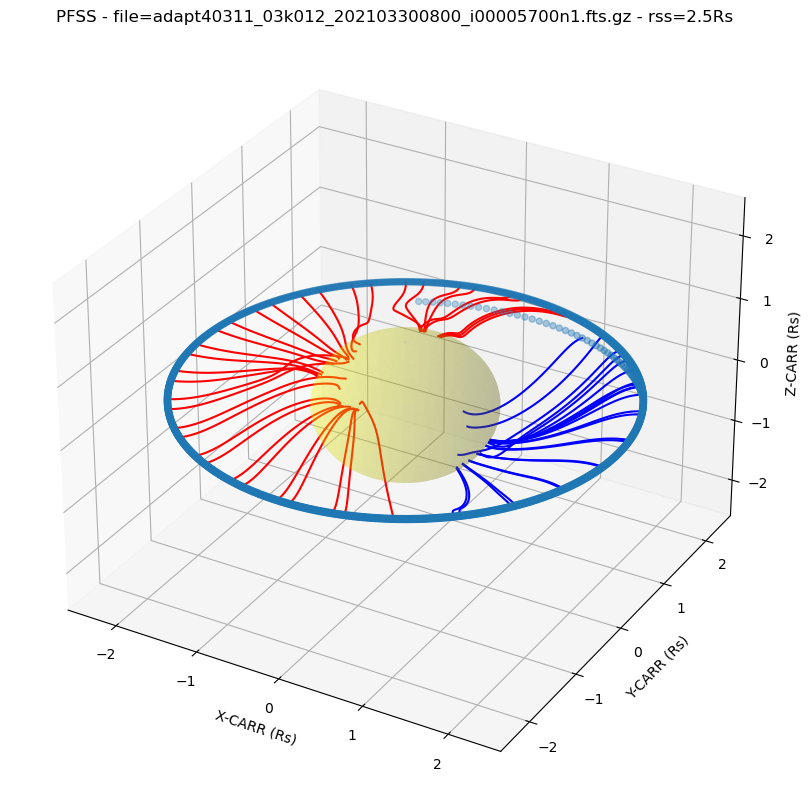

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# Make a fake sphere to represent the Sun
lonm,latm = np.meshgrid(np.linspace(0,360,180)*u.deg,
                        np.linspace(-90,90,90)*u.deg)
xm,ym,zm = np.cos(latm)*np.cos(lonm),np.cos(latm)*np.sin(lonm),np.sin(latm)
ax.plot_surface(xm,ym,zm,alpha=0.2,color="yellow")

color_dict = {-1:"blue",0:"black",1:"red"}
for f in flines_psp[::24] :
    fcoords = f.coords
    fcoords.representation_type="cartesian"
    ax.plot(fcoords.x.to("R_sun"),
            fcoords.y.to("R_sun"),
            fcoords.z.to("R_sun"),
            color = color_dict.get(f.polarity)
           )
    
psp_at_source_surface.representation_type="cartesian"
ax.scatter(psp_at_source_surface.x,psp_at_source_surface.y,psp_at_source_surface.z)
    
ax.set_xlabel("X-CARR (Rs)")
ax.set_ylabel("Y-CARR (Rs)")
ax.set_zlabel("Z-CARR (Rs)")

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_zlim([-2.5,2.5])

ax.set_title(f"PFSS - file={os.path.basename(filename)} - rss=2.5Rs")

Note the full magnetic connection in this exercise is both the Parker spiral part __and__ the PFSS traced field line part.

### Exercises

1) Go back to the `adapt2pfsspy` and use the `realization` keyword to run a PFSS model for each of the 12 realizations in the ADAPT fits file we downloaded. Plot and explore how the neutral line/HCS varies across the different inputs.

2) Run a PFSS model for a few different values of Rss and plot a coronal hole map like we did in part 6 for each height. What is the qualitative relationship between these maps and the source surface height?

3) Another useful field line property implemented in `pfsspy` is the magnetic expansion factor, which we didn't touch on in this notebook. This is the ratio of the field strength at an open field lines source surface intersection with its photospheric field strength, relative to 1/R$^2$ scaling. A purely radial field line has an expansion factor of 1 and anything more curved has a smaller value. It is defined as :

$$
f_{exp} = \frac{B_R(R_{SS})R_{SS}^2}{B_R(1R_\odot)R_\odot^2}
$$

It has been shown (Wang & Sheeley [1990](https://ui.adsabs.harvard.edu/abs/1990ApJ...355..726W/abstract)) that this quantity is to some extent inversely proportional to solar wind speed in the inner heliosphere. This relationship has been much refined and alternatives proposed (such as distance to coronal hole boundary) however we can still evaluate it for PFSS models and see interesting structure.

Use the `pfss2flines` function defined above with `trace_from_SS`=`True` to get field lines on a grid seeded at the source surface. Use the field lines `expansion_factor` method and reshape it like we did with the coronal hole map to derive an expansion factor 2D map at the source surface. What structure do you see? Where on the Sun do you expect to see slower or faster solar wind according to this model? 